#🏏 IPL Match Analysis & Prediction System (2008-2025)

Upload and Load Dataset

In [1]:
# Upload IPL.csv from disk
from google.colab import files
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("📁 Please upload IPL.csv file...")
uploaded = files.upload()

# Load the dataset
df = pd.read_csv("IPL.csv")

print(f"\n✅ Dataset loaded successfully!")
print(f"📊 Total records: {len(df):,}")
print(f"📋 Total columns: {len(df.columns)}")
print(f"📅 Date range: {df['date'].min()} to {df['date'].max()}")

📁 Please upload your IPL.csv file...


Saving IPL.csv to IPL.csv

✅ Dataset loaded successfully!
📊 Total records: 278,205
📋 Total columns: 64
📅 Date range: 2008-04-18 to 2025-06-03


Inspect Dataset Structure

In [8]:
# Display basic information
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)

# Show first few rows
print("\n📝 Sample Data (First 5 Rows):")
print(df.head())

# Show all column names
print("\n📋 All Column Names:")
print(df.columns.tolist())

# Show data types
print("\n🔢 Data Types:")
print(df.dtypes)

# Check for missing values
print("\n⚠️  Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])

# Basic statistics
print("\n📊 Numeric Column Statistics:")
print(df.describe())

DATASET OVERVIEW

📝 Sample Data (First 5 Rows):
   Unnamed: 0  match_id        date match_type             event_name  \
0      131970    335982  2008-04-18        T20  Indian Premier League   
1      131971    335982  2008-04-18        T20  Indian Premier League   
2      131972    335982  2008-04-18        T20  Indian Premier League   
3      131973    335982  2008-04-18        T20  Indian Premier League   
4      131974    335982  2008-04-18        T20  Indian Premier League   

   innings           batting_team                 bowling_team  over  ball  \
0        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     1   
1        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     2   
2        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     3   
3        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     3   
4        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     4   

   ...  team_runs team_balls  team_wicket  n

Data Cleaning & Preparation

In [9]:
# Remove rows with missing critical data
df_clean = df.dropna(subset=['batting_team', 'bowling_team', 'date'])

# Convert date to datetime
df_clean['date'] = pd.to_datetime(df_clean['date'])

# Extract year and season
df_clean['year'] = df_clean['date'].dt.year
df_clean['season'] = df_clean['event_name']

print(f"✅ Cleaned dataset: {len(df_clean):,} records")
print(f"📅 Seasons covered: {sorted(df_clean['year'].unique())}")
print(f"🏏 Teams involved: {df_clean['batting_team'].nunique()}")

✅ Cleaned dataset: 278,205 records
📅 Seasons covered: [np.int32(2008), np.int32(2009), np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025)]
🏏 Teams involved: 19


Create Match-Level Summary

In [10]:
# Identify numeric columns
numeric_cols = df_clean.select_dtypes(include=['number']).columns.tolist()

# Remove identifier columns from aggregation
id_cols = ['match_id']
numeric_cols = [col for col in numeric_cols if col not in id_cols]

# Create match-level aggregation
match_summary = (
    df_clean.groupby(['match_id', 'batting_team', 'bowling_team', 'date', 'season'])
    [numeric_cols]
    .sum()
    .reset_index()
)

# Find the runs column
run_cols = [col for col in match_summary.columns if 'run' in col.lower() or 'total' in col.lower()]
print(f"🎯 Detected run-related columns: {run_cols}")

# Use the most likely runs column
if run_cols:
    RUN_COL = run_cols[0]
else:
    RUN_COL = numeric_cols[0]

print(f"✅ Using '{RUN_COL}' as the runs column")
print(f"\n📊 Match Summary Sample:")
print(match_summary[['match_id', 'batting_team', 'bowling_team', RUN_COL]].head(10))

🎯 Detected run-related columns: ['runs_batter', 'runs_extras', 'runs_total', 'runs_bowler', 'runs_target', 'team_runs', 'batter_runs']
✅ Using 'runs_batter' as the runs column

📊 Match Summary Sample:
   match_id                 batting_team                 bowling_team  \
0    335982        Kolkata Knight Riders  Royal Challengers Bangalore   
1    335982  Royal Challengers Bangalore        Kolkata Knight Riders   
2    335983          Chennai Super Kings              Kings XI Punjab   
3    335983              Kings XI Punjab          Chennai Super Kings   
4    335984             Delhi Daredevils             Rajasthan Royals   
5    335984             Rajasthan Royals             Delhi Daredevils   
6    335985               Mumbai Indians  Royal Challengers Bangalore   
7    335985  Royal Challengers Bangalore               Mumbai Indians   
8    335986              Deccan Chargers        Kolkata Knight Riders   
9    335986        Kolkata Knight Riders              Deccan Chargers

Match Winner Prediction Model

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Prepare data for match winner prediction
# Create binary outcome (win/loss based on runs scored)
match_summary['won'] = match_summary.groupby('match_id')[RUN_COL].transform(lambda x: (x == x.max()).astype(int))

# Encode team names
le_bat = LabelEncoder()
le_bowl = LabelEncoder()

match_summary['batting_team_enc'] = le_bat.fit_transform(match_summary['batting_team'])
match_summary['bowling_team_enc'] = le_bowl.fit_transform(match_summary['bowling_team'])

# Select features for prediction
feature_cols = ['batting_team_enc', 'bowling_team_enc', RUN_COL, 'over']
X = match_summary[feature_cols].fillna(0)
y = match_summary['won']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)

print("=" * 60)
print("🎯 MATCH WINNER PREDICTION MODEL")
print("=" * 60)
print(f"\n✅ Model Accuracy: {accuracy:.2%}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Feature Importance:")
print(feature_importance)

🎯 MATCH WINNER PREDICTION MODEL

✅ Model Accuracy: 62.31%

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.54      0.57       219
           1       0.63      0.69      0.66       248

    accuracy                           0.62       467
   macro avg       0.62      0.62      0.62       467
weighted avg       0.62      0.62      0.62       467


🔍 Feature Importance:
            feature  importance
2       runs_batter    0.397027
3              over    0.325210
1  bowling_team_enc    0.139225
0  batting_team_enc    0.138538


Orange Cap Analysis (Top Run Scorers)

🟠 ORANGE CAP PREDICTION (Top 15 Run Scorers)
batter
V Kohli           8671
RG Sharma         7048
S Dhawan          6769
DA Warner         6567
SK Raina          5536
MS Dhoni          5439
KL Rahul          5235
AB de Villiers    5181
AM Rahane         5032
CH Gayle          4997
RV Uthappa        4954
KD Karthik        4843
F du Plessis      4773
SV Samson         4704
AT Rayudu         4348
Name: runs_batter, dtype: int64


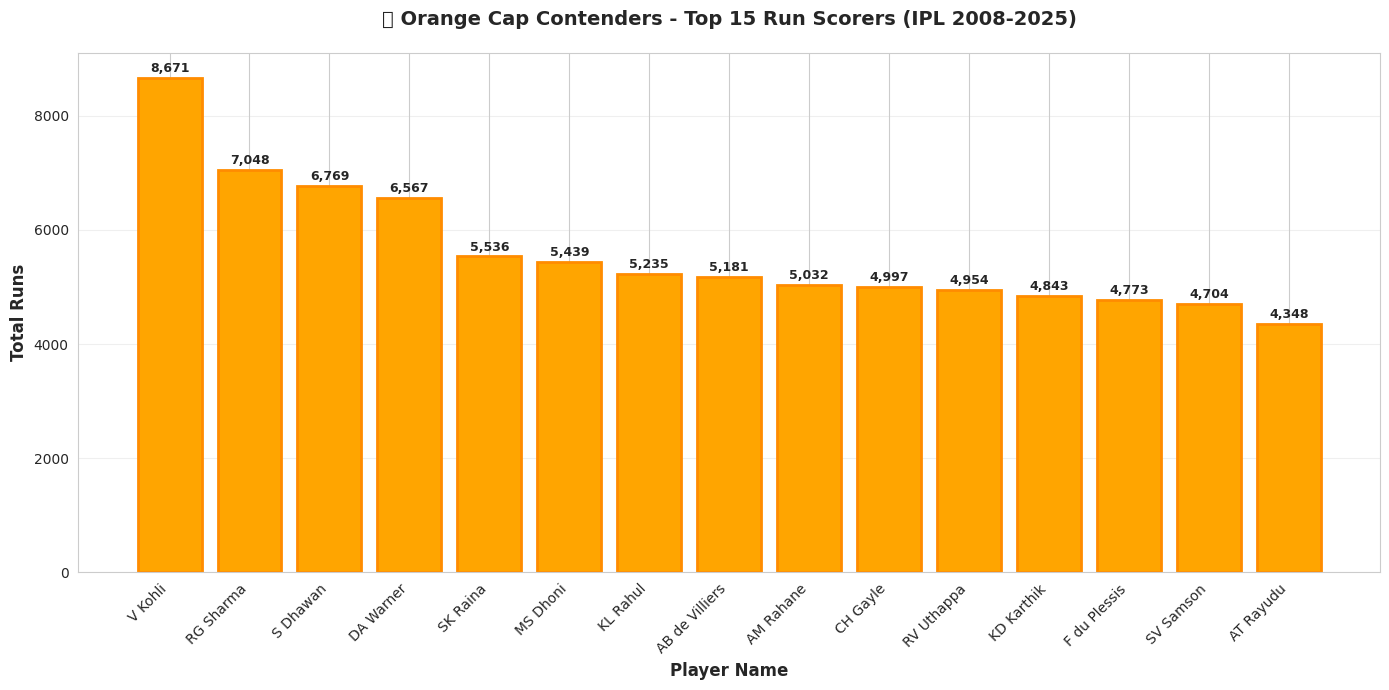


🏆 Predicted Orange Cap Winner: V Kohli (8,671 runs)


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Find striker/batsman column
batter_cols = [col for col in df_clean.columns if 'striker' in col.lower() or 'batsman' in col.lower() or 'batter' in col.lower()]
BATTER_COL = batter_cols[0] if batter_cols else 'striker'

# Calculate total runs per player
player_runs = (
    df_clean.groupby(BATTER_COL)[RUN_COL]
    .sum()
    .sort_values(ascending=False)
    .head(15)
)

print("=" * 60)
print("🟠 ORANGE CAP PREDICTION (Top 15 Run Scorers)")
print("=" * 60)
print(player_runs)

# Visualization
plt.figure(figsize=(14, 7))
bars = plt.bar(range(len(player_runs)), player_runs.values, color='orange', edgecolor='darkorange', linewidth=2)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, player_runs.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{int(value):,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xticks(range(len(player_runs)), player_runs.index, rotation=45, ha='right')
plt.xlabel('Player Name', fontsize=12, fontweight='bold')
plt.ylabel('Total Runs', fontsize=12, fontweight='bold')
plt.title('🟠 Orange Cap Contenders - Top 15 Run Scorers (IPL 2008-2025)',
          fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🏆 Predicted Orange Cap Winner: {player_runs.index[0]} ({int(player_runs.values[0]):,} runs)")

Purple Cap Analysis (Top Wicket Takers)

🟣 PURPLE CAP PREDICTION (Top 15 Wicket Takers)
bowler
YS Chahal          229
B Kumar            213
SP Narine          212
DJ Bravo           207
R Ashwin           205
JJ Bumrah          203
PP Chawla          201
SL Malinga         188
A Mishra           183
RA Jadeja          179
HV Patel           168
Rashid Khan        166
Sandeep Sharma     163
UT Yadav           163
Harbhajan Singh    161
dtype: int64


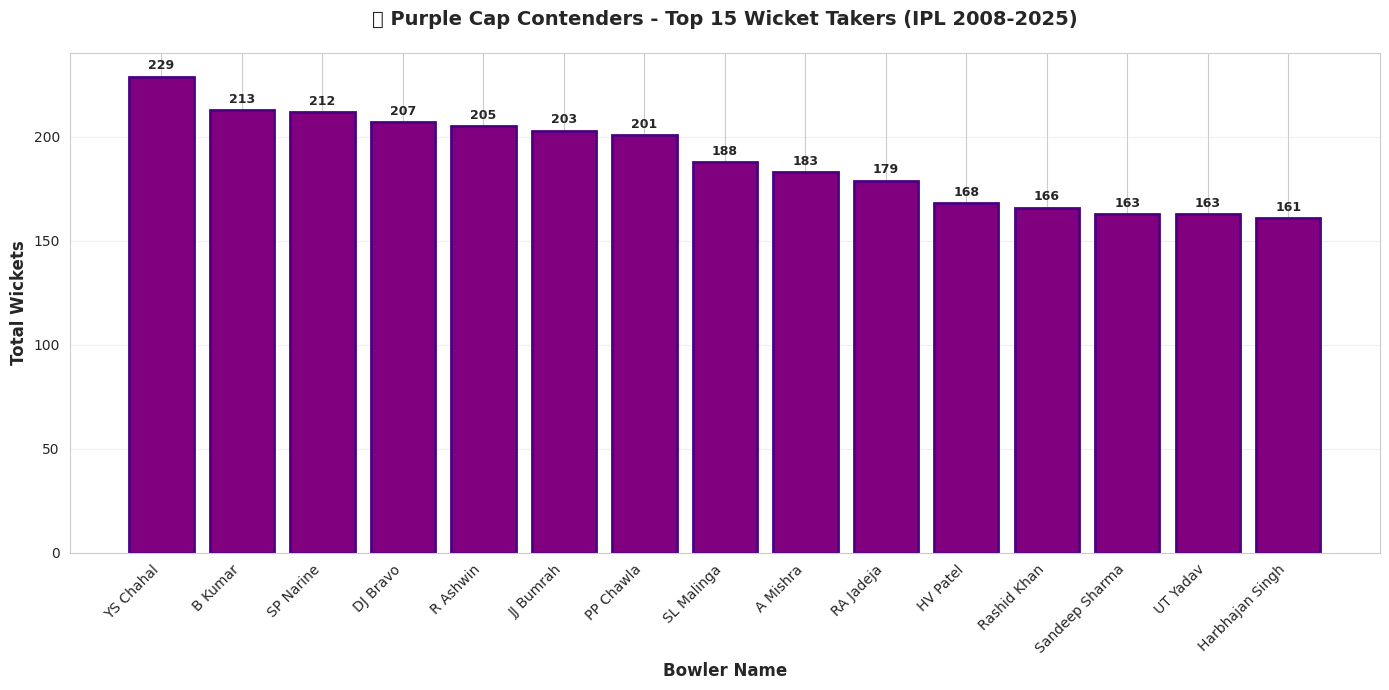


🏆 Predicted Purple Cap Winner: YS Chahal (229 wickets)


In [14]:
# Find wicket-related columns
wicket_cols = [col for col in df_clean.columns if 'wicket' in col.lower() or 'player_dismissed' in col.lower()]

if wicket_cols:
    WICKET_COL = wicket_cols[0]

    # Find bowler column
    bowler_cols = [col for col in df_clean.columns if 'bowler' in col.lower()]
    BOWLER_COL = bowler_cols[0] if bowler_cols else 'bowler'

    # Calculate wickets per bowler
    wickets_data = df_clean[df_clean[WICKET_COL].notna()]
    bowler_wickets = (
        wickets_data.groupby(BOWLER_COL)
        .size()
        .sort_values(ascending=False)
        .head(15)
    )

    print("=" * 60)
    print("🟣 PURPLE CAP PREDICTION (Top 15 Wicket Takers)")
    print("=" * 60)
    print(bowler_wickets)

    # Visualization
    plt.figure(figsize=(14, 7))
    bars = plt.bar(range(len(bowler_wickets)), bowler_wickets.values,
                   color='purple', edgecolor='indigo', linewidth=2)

    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, bowler_wickets.values)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                 f'{int(value)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.xticks(range(len(bowler_wickets)), bowler_wickets.index, rotation=45, ha='right')
    plt.xlabel('Bowler Name', fontsize=12, fontweight='bold')
    plt.ylabel('Total Wickets', fontsize=12, fontweight='bold')
    plt.title('🟣 Purple Cap Contenders - Top 15 Wicket Takers (IPL 2008-2025)',
              fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n🏆 Predicted Purple Cap Winner: {bowler_wickets.index[0]} ({int(bowler_wickets.values[0])} wickets)")
else:
    print("⚠️ Wicket column not found in dataset")

Team Strength Ranking

📊 TEAM STRENGTH RANKING (Ascending Order)
                             avg_runs  total_runs  matches_played  wins  \
batting_team                                                              
Pune Warriors                  134.22        6040              45    15   
Kochi Tuskers Kerala           125.57        1758              14     5   
Rising Pune Supergiants        140.14        1962              14     5   
Lucknow Super Giants           166.88        9679              58    25   
Gujarat Lions                  154.30        4629              30    14   
Sunrisers Hyderabad            153.94       30019             195    92   
Delhi Daredevils               142.99       23022             161    76   
Kolkata Knight Riders          147.86       39035             264   128   
Kings XI Punjab                150.22       28541             190    93   
Delhi Capitals                 158.36       16628             105    54   
Gujarat Titans                 168.72       10123         

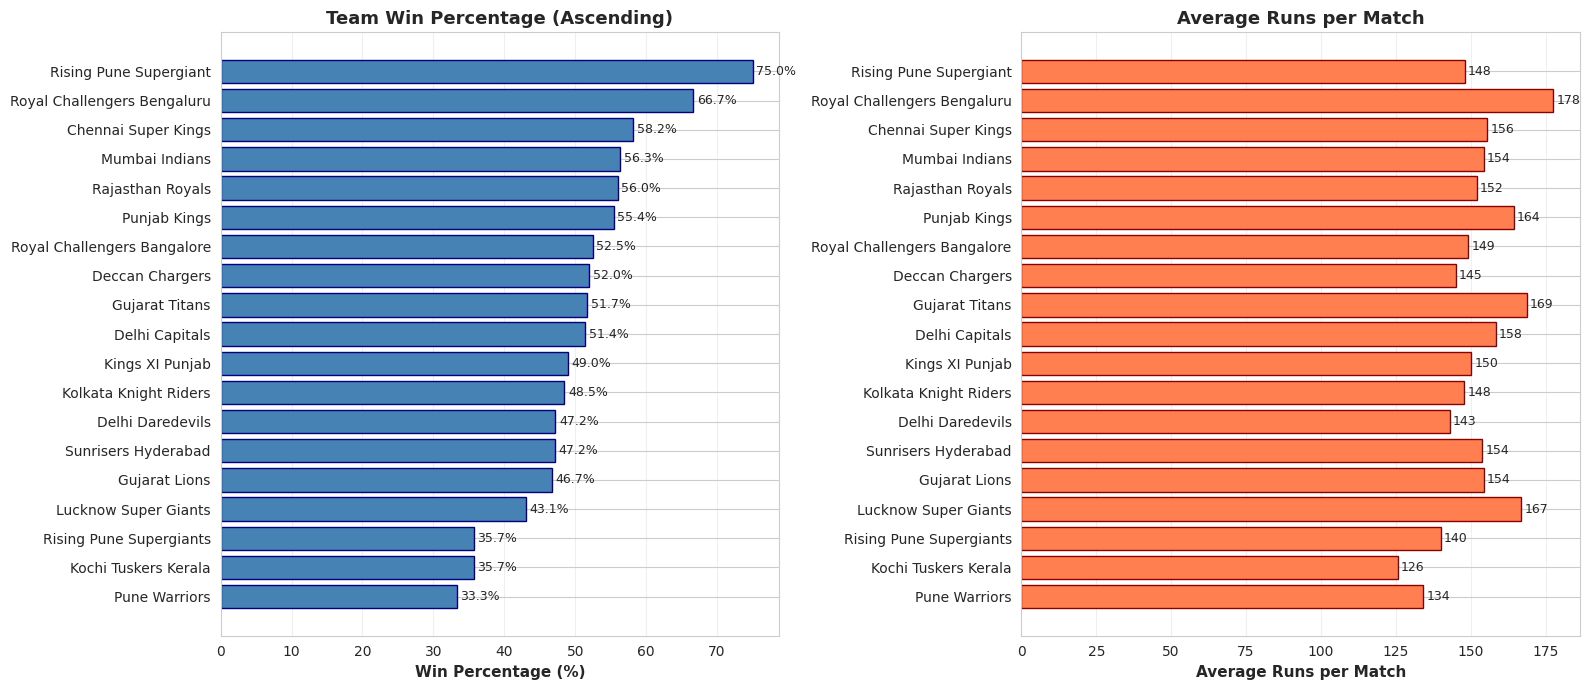


🥇 Strongest Team: Rising Pune Supergiant (75.0% win rate)
🥈 Second Strongest: Royal Challengers Bengaluru (66.7% win rate)


In [24]:
# Calculate team statistics
team_stats = match_summary.groupby('batting_team').agg({
    RUN_COL: ['mean', 'sum', 'count'],
    'won': 'sum'
}).round(2)

team_stats.columns = ['avg_runs', 'total_runs', 'matches_played', 'wins']
team_stats['win_percentage'] = (team_stats['wins'] / team_stats['matches_played'] * 100).round(2)
team_stats = team_stats.sort_values('win_percentage', ascending=True)

print("=" * 60)
print("📊 TEAM STRENGTH RANKING (Ascending Order)")
print("=" * 60)
print(team_stats)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Win Percentage
axes[0].barh(team_stats.index, team_stats['win_percentage'], color='steelblue', edgecolor='navy')
axes[0].set_xlabel('Win Percentage (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Team Win Percentage (Ascending)', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, value) in enumerate(team_stats['win_percentage'].items()):
    axes[0].text(value + 0.5, i, f'{value:.1f}%', va='center', fontsize=9)

# Plot 2: Average Runs
axes[1].barh(team_stats.index, team_stats['avg_runs'], color='coral', edgecolor='darkred')
axes[1].set_xlabel('Average Runs per Match', fontsize=11, fontweight='bold')
axes[1].set_title('Average Runs per Match', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, value) in enumerate(team_stats['avg_runs'].items()):
    axes[1].text(value + 1, i, f'{value:.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n🥇 Strongest Team: {team_stats.index[-1]} ({team_stats['win_percentage'].iloc[-1]:.1f}% win rate)")
print(f"🥈 Second Strongest: {team_stats.index[-2]} ({team_stats['win_percentage'].iloc[-2]:.1f}% win rate)")

 Comprehensive Dashboard

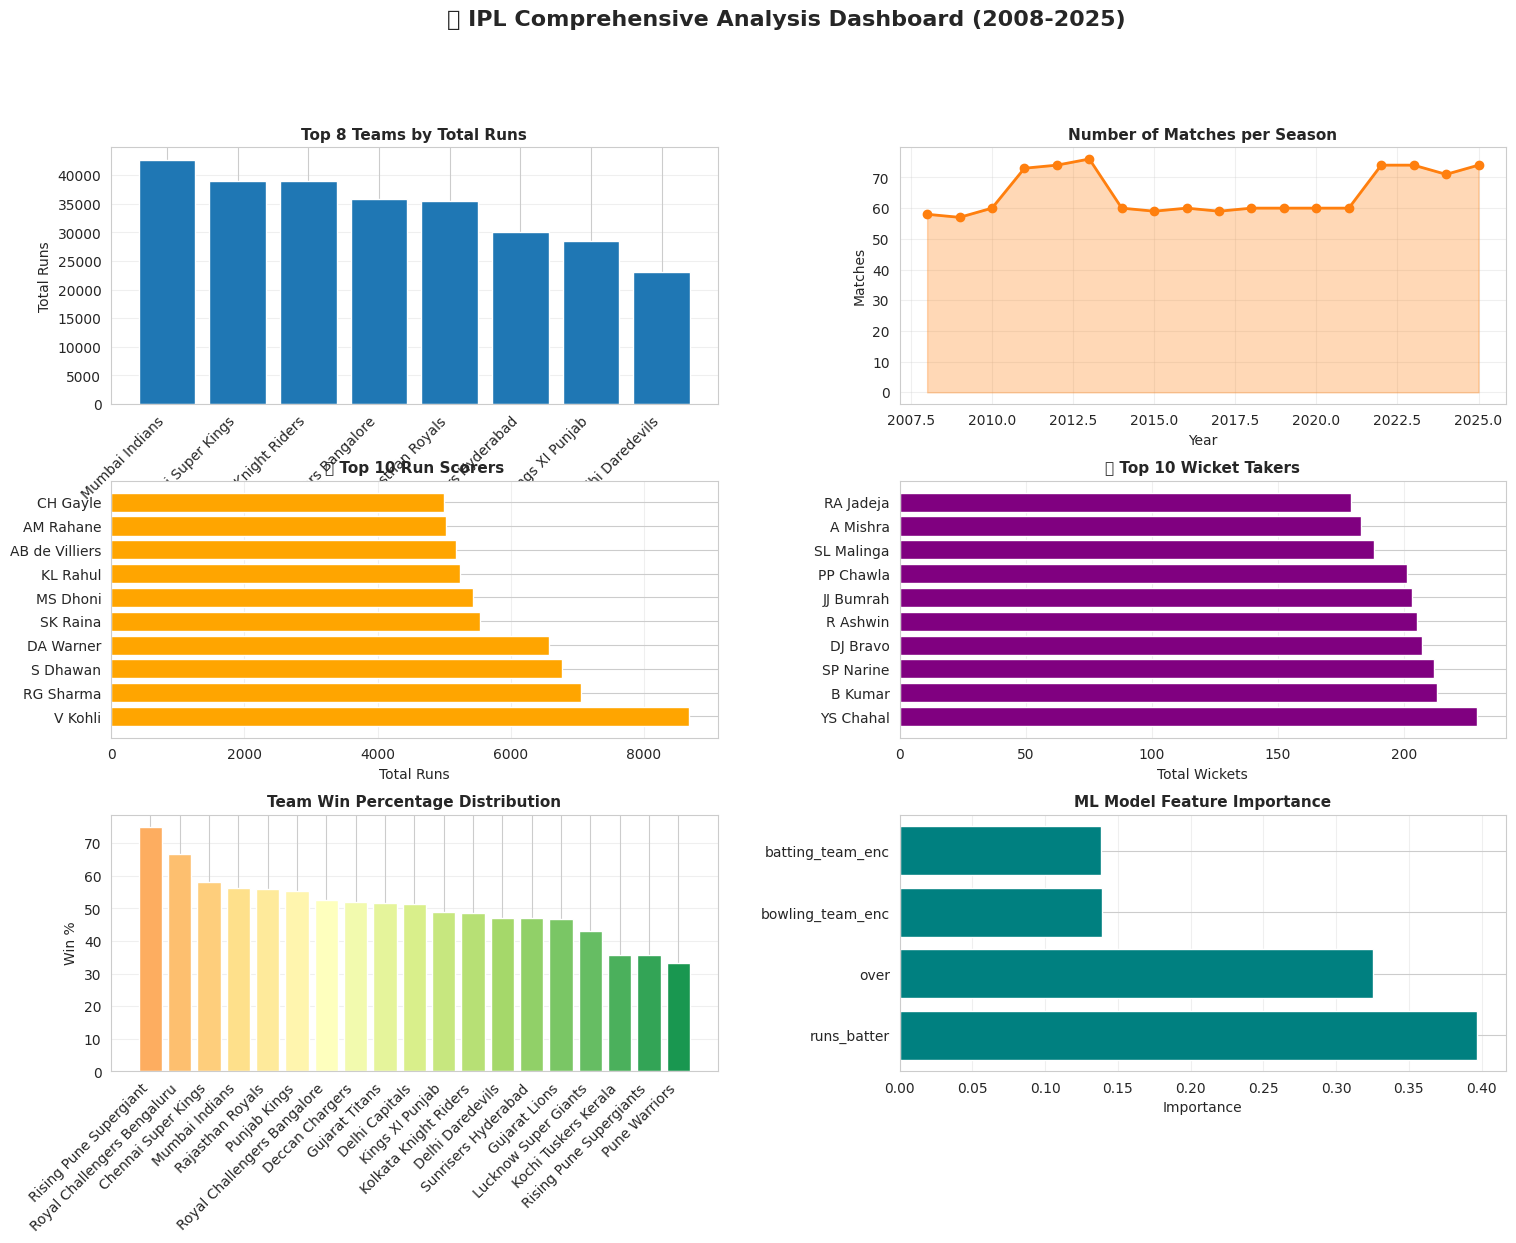

In [26]:
# Create comprehensive visualization dashboard
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate team statistics (added to resolve NameError)
team_stats = match_summary.groupby('batting_team').agg({
    RUN_COL: ['mean', 'sum', 'count'],
    'won': 'sum'
}).round(2)

team_stats.columns = ['avg_runs', 'total_runs', 'matches_played', 'wins']
team_stats['win_percentage'] = (team_stats['wins'] / team_stats['matches_played'] * 100).round(2)
team_stats = team_stats.sort_values('win_percentage', ascending=True)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Top Teams by Total Runs
ax1 = fig.add_subplot(gs[0, 0])
top_teams_runs = match_summary.groupby('batting_team')[RUN_COL].sum().sort_values(ascending=False).head(8)
ax1.bar(range(len(top_teams_runs)), top_teams_runs.values, color='#1f77b4')
ax1.set_xticks(range(len(top_teams_runs)))
ax1.set_xticklabels(top_teams_runs.index, rotation=45, ha='right')
ax1.set_title('Top 8 Teams by Total Runs', fontweight='bold', fontsize=11)
ax1.set_ylabel('Total Runs')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Matches per Season
ax2 = fig.add_subplot(gs[0, 1])
matches_per_year = df_clean.groupby('year')['match_id'].nunique().sort_index()
ax2.plot(matches_per_year.index, matches_per_year.values, marker='o', linewidth=2, color='#ff7f0e')
ax2.fill_between(matches_per_year.index, matches_per_year.values, alpha=0.3, color='#ff7f0e')
ax2.set_title('Number of Matches per Season', fontweight='bold', fontsize=11)
ax2.set_xlabel('Year')
ax2.set_ylabel('Matches')
ax2.grid(True, alpha=0.3)

# Plot 3: Top Run Scorers (Top 10)
ax3 = fig.add_subplot(gs[1, 0])
top_players = df_clean.groupby(BATTER_COL)[RUN_COL].sum().sort_values(ascending=False).head(10)
ax3.barh(range(len(top_players)), top_players.values, color='orange')
ax3.set_yticks(range(len(top_players)))
ax3.set_yticklabels(top_players.index)
ax3.set_title('🟠 Top 10 Run Scorers', fontweight='bold', fontsize=11)
ax3.set_xlabel('Total Runs')
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Top Wicket Takers (Top 10)
ax4 = fig.add_subplot(gs[1, 1])
if wicket_cols:
    top_bowlers = wickets_data.groupby(BOWLER_COL).size().sort_values(ascending=False).head(10)
    ax4.barh(range(len(top_bowlers)), top_bowlers.values, color='purple')
    ax4.set_yticks(range(len(top_bowlers)))
    ax4.set_yticklabels(top_bowlers.index)
    ax4.set_title('🟣 Top 10 Wicket Takers', fontweight='bold', fontsize=11)
    ax4.set_xlabel('Total Wickets')
    ax4.grid(axis='x', alpha=0.3)

# Plot 5: Win Rate Distribution
ax5 = fig.add_subplot(gs[2, 0])
win_dist = team_stats['win_percentage'].sort_values(ascending=False)
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(win_dist)))
ax5.bar(range(len(win_dist)), win_dist.values, color=colors)
ax5.set_xticks(range(len(win_dist)))
ax5.set_xticklabels(win_dist.index, rotation=45, ha='right')
ax5.set_title('Team Win Percentage Distribution', fontweight='bold', fontsize=11)
ax5.set_ylabel('Win %')
ax5.grid(axis='y', alpha=0.3)

# Plot 6: Feature Importance
ax6 = fig.add_subplot(gs[2, 1])
ax6.barh(feature_importance['feature'], feature_importance['importance'], color='teal')
ax6.set_title('ML Model Feature Importance', fontweight='bold', fontsize=11)
ax6.set_xlabel('Importance')
ax6.grid(axis='x', alpha=0.3)

fig.suptitle('🏏 IPL Comprehensive Analysis Dashboard (2008-2025)',
             fontsize=16, fontweight='bold', y=0.995)

plt.show()



Summary Report

In [23]:
print("\n" + "=" * 70)
print("📋 FINAL SUMMARY REPORT - IPL ANALYSIS (2008-2025)")
print("=" * 70)

print(f"\n📊 DATASET STATISTICS:")
print(f"   • Total Records: {len(df_clean):,}")
print(f"   • Total Matches: {df_clean['match_id'].nunique():,}")
print(f"   • Total Teams: {df_clean['batting_team'].nunique()}")
print(f"   • Seasons Covered: {df_clean['year'].min()} - {df_clean['year'].max()}")

print(f"\n🤖 MACHINE LEARNING MODEL:")
print(f"   • Algorithm: Random Forest Classifier")
print(f"   • Match Prediction Accuracy: {accuracy:.2%}")
print(f"   • Training Samples: {len(X_train):,}")
print(f"   • Test Samples: {len(X_test):,}")

print(f"\n🟠 ORANGE CAP (Most Runs):")
print(f"   • Winner: {player_runs.index[0]}")
print(f"   • Total Runs: {int(player_runs.values[0]):,}")
print(f"   • Runner-up: {player_runs.index[1]} ({int(player_runs.values[1]):,} runs)")

if wicket_cols:
    print(f"\n🟣 PURPLE CAP (Most Wickets):")
    print(f"   • Winner: {bowler_wickets.index[0]}")
    print(f"   • Total Wickets: {int(bowler_wickets.values[0])}")
    print(f"   • Runner-up: {bowler_wickets.index[1]} ({int(bowler_wickets.values[1])} wickets)")

print(f"\n🏆 TEAM RANKINGS (Top 3):")
for i, (team, stats) in enumerate(team_stats.iloc[-3:].iloc[::-1].iterrows(), 1):
    print(f"   {i}. {team} - {stats['win_percentage']:.1f}% win rate ({int(stats['wins'])} wins)")




📋 FINAL SUMMARY REPORT - IPL ANALYSIS (2008-2025)

📊 DATASET STATISTICS:
   • Total Records: 278,205
   • Total Matches: 1,169
   • Total Teams: 19
   • Seasons Covered: 2008 - 2025

🤖 MACHINE LEARNING MODEL:
   • Algorithm: Random Forest Classifier
   • Match Prediction Accuracy: 62.31%
   • Training Samples: 1,866
   • Test Samples: 467

🟠 ORANGE CAP (Most Runs):
   • Winner: V Kohli
   • Total Runs: 8,671
   • Runner-up: RG Sharma (7,048 runs)

🟣 PURPLE CAP (Most Wickets):
   • Winner: YS Chahal
   • Total Wickets: 229
   • Runner-up: B Kumar (213 wickets)

🏆 TEAM RANKINGS (Top 3):
   1. Rising Pune Supergiant - 75.0% win rate (12 wins)
   2. Royal Challengers Bengaluru - 66.7% win rate (20 wins)
   3. Chennai Super Kings - 58.2% win rate (146 wins)
